In [2]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats

In [3]:
from spacy.tokens import Doc
# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
#nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [4]:
doc = nlp("Den snabba bruna räven hoppar över den lata hunden.")
for token in doc:
    print(token.text, token.tag_, token.dep_, token.is_stop,[child for child in token.children])

Den DET det True []
snabba ADJ amod False []
bruna ADJ amod False []
räven NOUN nsubj False [Den, snabba, bruna]
hoppar VERB ROOT False [räven, hunden, .]
över ADP case True []
den DET det True []
lata ADJ amod False []
hunden NOUN obl False [över, den, lata]
. PUNCT punct False []


In [5]:
displacy.render(doc, style="dep", jupyter=True)

In [6]:
for token in doc: 
    print(token, [
        ('((%s))' if t is token else '%s') % t.text
        for t in token.subtree
    ])

Den ['((Den))']
snabba ['((snabba))']
bruna ['((bruna))']
räven ['Den', 'snabba', 'bruna', '((räven))']
hoppar ['Den', 'snabba', 'bruna', 'räven', '((hoppar))', 'över', 'den', 'lata', 'hunden', '.']
över ['((över))']
den ['((den))']
lata ['((lata))']
hunden ['över', 'den', 'lata', '((hunden))']
. ['((.))']


In [7]:
for sent in doc.sents:
    print(sent.root, list(sent.root.lefts), list(list(sent.root.lefts)[0].children))

hoppar [räven] [Den, snabba, bruna]


In [8]:
def processDoc(doc):
    sentence = list(doc.sents)[0]
    root = sentence.root
    print("Sentence: ", sentence)
    print("Root: ", root)
    print(numWords(root))
      
def recurseTokens(token): 
    print("Processing token: ", token)
    if(list(token.children) == []): 
        print("Leaf node")
        return token
    print("Left tokens: ", [recurseTokens(t) for t in token.lefts], "of token", token)
    print("Right tokens: ", [recurseTokens(t) for t in token.rights], "of token", token)
    
def numWords(token):
    if(len(list(token.children))==0): return 1
    return 1 + sum([numWords(c) for c in token.children])

In [9]:
processDoc(doc)

Sentence:  Den snabba bruna räven hoppar över den lata hunden.
Root:  hoppar
10


In [10]:
# Look at distribution of sentence lengths across languages/times
"""
    Process: pass in the function that will process individual sentences
    Returns whatever process returns
"""
def traverseSwed(filepath, process, relative=False):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    ag = []
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                pos.append(elem.attrib['pos'])
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            tok = list(doc.sents)[0].root
            if process != sentenceLength and relative:
                ag += [process(tok)/len(doc)]
            else: 
                ag += [process(tok)]
            
            words = ""
            pos = []
            i += 1
        if i == 10000: break
    return ag
            
def traverseFin(filepath, process, relative=False):
    ag = []
    num_sentences = 0
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            if num_sentences == 10000: return sum_overlaps / num_sentences
            # Start of sentence
            if line[:9] == "<sentence": 
                #print("start sentence")
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                if(len(words)) == 0: continue
                sent = " ".join(words)
                # print(words)
                doc = nlp(sent)
                tok = list(doc.sents)[0].root
                if process != sentenceLength and relative: 
                    ag += [process(tok)/len(doc)]
                else: 
                    ag += [process(tok)]
                
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 10000: break
    
    return ag

def sentenceLength(tok):
    # print(doc, len(doc))
    return len(list(tok.children)) + 1

def treeDepth(tok):
    if len(list(tok.children)) == 0: return 0 
    
    depths = np.array([treeDepth(c) for c in tok.children]).flatten()
    return max(depths) + 1

def numLeafs(tok): 
    if len(list(tok.children)) == 0: return 1
    
    leafs = np.array([numLeafs(c) for c in tok.children]).flatten()
    return sum(leafs)

In [11]:
tok = list(doc.sents)[0].root
numLeafs(tok)

7

In [12]:
def showResults(res1, res2, label1, label2, title):
    plt.hist(res1, alpha=0.5, label=label1)
    plt.hist(res2, alpha=0.5, label=label2)
    plt.legend()
    plt.title(title)
    plt.show()

    print(f"{label1} stats: {scipy.stats.describe(res1)}")
    print(f"{label2} stats: {scipy.stats.describe(res2)}")
    print("\nIndependence t-test: ", scipy.stats.ttest_ind(res1, res2, equal_var=False))

### Metric: Number of Leaves

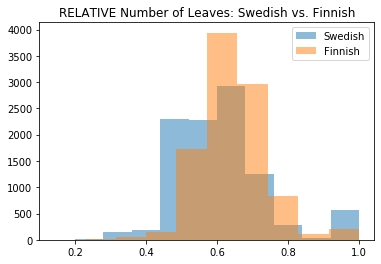

Swedish stats: DescribeResult(nobs=10000, minmax=(0.2, 1.0), mean=0.622199584485061, variance=0.017564287736283848, skewness=0.983956539621908, kurtosis=1.7549431562711506)
Finnish stats: DescribeResult(nobs=10000, minmax=(0.14285714285714285, 1.0), mean=0.6364944859430554, variance=0.009627425164885376, skewness=0.656862938298169, kurtosis=2.798213301495836)

Independence t-test:  Ttest_indResult(statistic=-8.668877835900311, pvalue=4.7200466121726395e-18)


In [34]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
depthsSwe = traverseSwed(file_path, numLeafs, True)
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
depthsFin = traverseFin(file_path, numLeafs, True)
showResults(depthsSwe, depthsFin, "Swedish", "Finnish", "RELATIVE Number of Leaves: Swedish vs. Finnish")

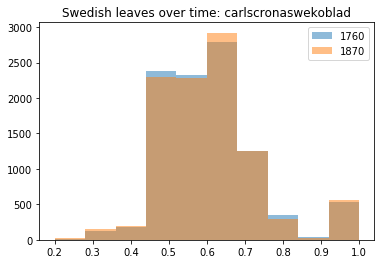

1760 stats: DescribeResult(nobs=10000, minmax=(0.2, 1.0), mean=0.6232994386797495, variance=0.017290473216830807, skewness=0.9779399622219987, kurtosis=1.6154319877049463)
1870 stats: DescribeResult(nobs=10000, minmax=(0.2, 1.0), mean=0.622199584485061, variance=0.017564287736283848, skewness=0.983956539621908, kurtosis=1.7549431562711506)

Independence t-test:  Ttest_indResult(statistic=0.5891203993496404, pvalue=0.5557871649228925)


In [35]:
# Look at depth of a single Swedish newspaper over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
depthsSweOld = traverseSwed(file_path, numLeafs, True)
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
depthsSweNew = traverseSwed(file_path, numLeafs, True)
showResults(depthsSweOld, depthsSweNew, "1760", "1870", "Swedish proportion of leaves over time: carlscronaswekoblad")

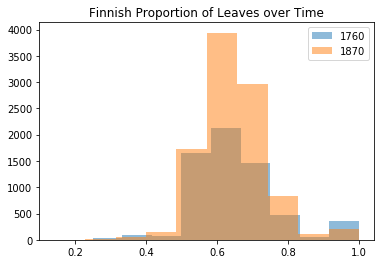

1760 stats: DescribeResult(nobs=6336, minmax=(0.16666666666666666, 1.0), mean=0.6380019791733798, variance=0.01543930764452022, skewness=1.0753983626441768, kurtosis=2.143917328698291)
1870 stats: DescribeResult(nobs=10000, minmax=(0.14285714285714285, 1.0), mean=0.6364944859430554, variance=0.009627425164885376, skewness=0.656862938298169, kurtosis=2.798213301495836)

Independence t-test:  Ttest_indResult(statistic=0.8176128802520176, pvalue=0.41359563197570615)


In [36]:
# Look at depth evoluion across Finnish over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1782.vrt")
lengthsFinOld = traverseFin(file_path, numLeafs, True)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFinNew = traverseFin(file_path, numLeafs, True)

showResults(lengthsFinOld, lengthsFinNew, "1760", "1870", "Finnish Proportion of Leaves over Time")

### Metric: Tree Depth

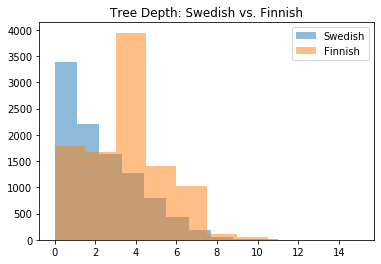

Swedish stats: DescribeResult(nobs=10000, minmax=(0, 11), mean=2.582, variance=3.0883848384838486, skewness=0.8574498523332551, kurtosis=0.46993688688931057)
Finnish stats: DescribeResult(nobs=10000, minmax=(0, 15), mean=3.3696, variance=3.2897248124812486, skewness=0.5029653805132636, kurtosis=0.34221078678945194)

Independence t-test:  Ttest_indResult(statistic=-31.186003036196954, pvalue=1.6115072655423371e-208)


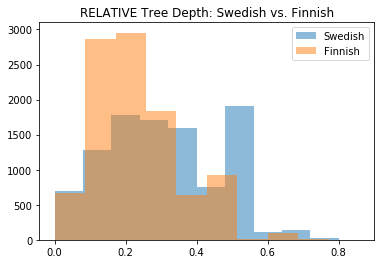

Swedish stats: DescribeResult(nobs=10000, minmax=(0.0, 0.8), mean=0.295911170832094, variance=0.023985873595477183, skewness=0.1286856895986828, kurtosis=-0.5669834316620967)
Finnish stats: DescribeResult(nobs=10000, minmax=(0.0, 0.8571428571428571), mean=0.2399408232712998, variance=0.01685734665519656, skewness=0.7828683577405711, kurtosis=0.22597045465533405)

Independence t-test:  Ttest_indResult(statistic=27.694786122512024, pvalue=1.325042658467669e-165)


In [33]:
# Depth of Finnish vs Swedish sentences
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
depthsSwe = traverseSwed(file_path, treeDepth, False)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
depthsFin = traverseFin(file_path, treeDepth, False)

showResults(depthsSwe, depthsFin, "Swedish", "Finnish", "Tree Depth: Swedish vs. Finnish")

# Relative to sentence length
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
depthsSwe = traverseSwed(file_path, treeDepth, True)
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
depthsFin = traverseFin(file_path, treeDepth, True)
showResults(depthsSwe, depthsFin, "Swedish", "Finnish", "RELATIVE Tree Depth: Swedish vs. Finnish")

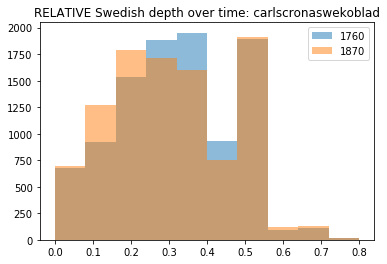

1760 stats: DescribeResult(nobs=10000, minmax=(0.0, 0.8), mean=0.30624221717557054, variance=0.022078883625551125, skewness=-0.04297873852520558, kurtosis=-0.41915132208966677)
1870 stats: DescribeResult(nobs=10000, minmax=(0.0, 0.8), mean=0.295911170832094, variance=0.023985873595477183, skewness=0.1286856895986828, kurtosis=-0.5669834316620967)

Independence t-test:  Ttest_indResult(statistic=4.813488254538261, pvalue=1.494032280383569e-06)


In [37]:
# Look at depth of a single Swedish newspaper over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
depthsSweOld = traverseSwed(file_path, treeDepth, True)

file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
depthsSweNew = traverseSwed(file_path, treeDepth, True)

showResults(depthsSweOld, depthsSweNew, "1760", "1870", "RELATIVE Swedish depth over time: carlscronaswekoblad")

In [ ]:
# Look at depth evoluion across Finnish over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1782.vrt")
lengthsFinOld = traverseFin(file_path, treeDepth, True)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFinNew = traverseFin(file_path, treeDepth, True)

showResults(lengthsFinOld, lengthsFinNew, "1760", "1870", "RELATIVE Finnish Depth over Time")

### Metric: Sentence Length

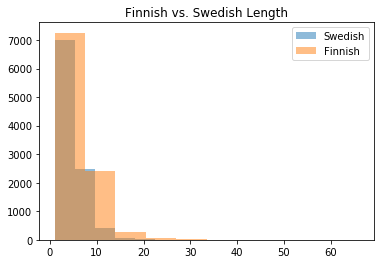

Swedish stats: DescribeResult(nobs=10000, minmax=(1, 44), mean=4.6169, variance=7.491483538353835, skewness=1.8271318778302976, kurtosis=9.21313178220388)
Finnish stats: DescribeResult(nobs=10000, minmax=(1, 66), mean=6.2034, variance=12.978726312631263, skewness=2.628760993995695, kurtosis=19.98546463772913)

Independence t-test:  Ttest_indResult(statistic=-35.06541062800456, pvalue=6.305552748042996e-261)


In [26]:
# Compare sentence lengths across languages for fixed time
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
lengthsSwe = traverseSwed(file_path, sentenceLength, False)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFin = traverseFin(file_path, sentenceLength, False)

showResults(lengthsSwe, lengthsFin, "Swedish", "Finnish", "Finnish vs. Swedish Length")

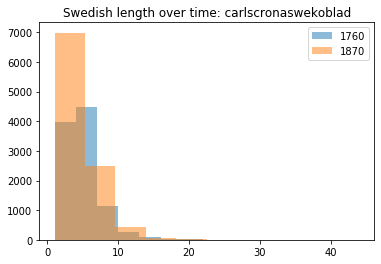

1760 stats: DescribeResult(nobs=10000, minmax=(1, 31), mean=4.3993, variance=6.2922887388738875, skewness=1.960009467481225, kurtosis=7.614865850081339)
1870 stats: DescribeResult(nobs=10000, minmax=(1, 44), mean=4.6169, variance=7.491483538353835, skewness=1.8271318778302976, kurtosis=9.21313178220388)

Independence t-test:  Ttest_indResult(statistic=-5.861042172105287, pvalue=4.6725014683531656e-09)


In [27]:
# Look at evoluion of a single Swedish newspaper over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1760.xml")
lengthsSweOld = traverseSwed(file_path, sentenceLength)

file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
lengthsSweNew = traverseSwed(file_path, sentenceLength)

showResults(lengthsSweOld, lengthsSweNew, "1760", "1870", "Swedish length over time: carlscronaswekoblad")

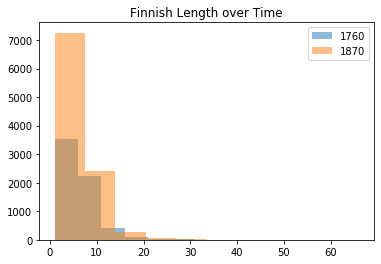

1760 stats: DescribeResult(nobs=6336, minmax=(1, 51), mean=5.830176767676767, variance=15.603357569379668, skewness=2.6037227825792746, kurtosis=14.279871981269508)
1870 stats: DescribeResult(nobs=10000, minmax=(1, 66), mean=6.2034, variance=12.978726312631263, skewness=2.628760993995695, kurtosis=19.98546463772913)

Independence t-test:  Ttest_indResult(statistic=-6.086175915826702, pvalue=1.190074583606639e-09)


In [32]:
# Look at evoluion across Finnish over time
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1782.vrt")
lengthsFinOld = traverseFin(file_path, sentenceLength)

file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
lengthsFinNew = traverseFin(file_path, sentenceLength)

showResults(lengthsFinOld, lengthsFinNew, "1760", "1870", "Finnish Length over Time")

In [30]:
def getExamplesSwe(file_path, process, mean, var, title, numexs, relative=True):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)
    ni = 0

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    ag = []
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                pos.append(elem.attrib['pos'])
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            tok = list(doc.sents)[0].root
            if relative:
                ag += [process(tok)/len(doc)]
            else: 
                ag += [process(tok)]
            if ag[-1] >= mean - var and ag[-1] <= mean + var:
                print("\n", doc)
                print(f'{title}: ', ag[-1])
                displacy.render(doc, style="dep", jupyter=True, options={"compact":True})
                ni += 1
            words = ""
            pos = []
            i += 1
        if i == 10000 or ni == numexs: break
            
def getExamplesFin(file_path, process, mean, var, title, numexs, relative=True):
    num_sentences = 0
    ni = 0
    ag = []
    with open(file_path, encoding='utf-8') as reader:
        words = []
        pos = []
        for line in reader:
            #if num_sentences == 10000: return sum_overlaps / num_sentences
            # Start of sentence
            if line[:9] == "<sentence": 
                #print("start sentence")
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                if(len(words)) == 0: continue
                sent = " ".join(words)
                # print(words)
                doc = nlp(sent)
                tok = list(doc.sents)[0].root
                if relative: 
                    ag += [process(tok)/len(doc)]
                else: 
                    ag += [process(tok)]

                if ag[-1] >= mean - var and ag[-1] <= mean + var:
                    print("\n", doc)
                    print(f'{title}: ', ag[-1], num_sentences)
                    displacy.render(doc, style="dep", jupyter=True, options={"compact":True})
                    ni +=1 
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 10000 or ni==numexs: break

In [ ]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
getExamplesSwe(file_path, numLeafs, 0.622199, 0.01756, "Leaves", 2)

In [ ]:
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
getExamplesFin(file_path, numLeafs, 0.63649, 0.0096274, "Leaves", 2)

In [ ]:
# RELATIVE Swedish Tree Depth
mean, var = 0.30624,  0.022078
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
getExamplesSwe(file_path, treeDepth, mean, var, "Depth", 2)

In [ ]:
# RELATIVE Finnish Tree Depth
mean, var = 0.29591, 0.023985
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
getExamplesFin(file_path, treeDepth, mean, var, "Depth", 2)

In [26]:
# ABSOLUTE Swedish Tree Depth
mean, var = 11, 1 #2.582,  3.0883
file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2","kubhist2-carlscronaswekoblad-1870.xml")
getExamplesSwe(file_path, treeDepth, mean, var, "Depth", 1, False)


 Anse verkligen Komiterade lagligt och rättvist ( för att ej tala om billigheten ) att båtsmannen skall vara skyldig åtnöjas med en penninge ersättning af tre rdr 75 öre rint för : en tunna råg , en tunna korn , ett lass hö oell ett lass halm ?
Depth:  11


In [31]:
# ABSOLUTE Finnish Tree Depth
mean, var =  15, 3 #3.3696, 3.2897
file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", "klk-sv-1870.vrt")
getExamplesFin(file_path, treeDepth, mean, var, "Depth", 1, False)


 Samma cistern tjenar om aftonen till badställe ! här twätta stora och sina sina ansigten cch nedkallade fötter , när solen haller pä att ga ned och arbctarne kallas tillsammans för att mottaga sin dagslön af uppsyningsmannen , som sitter pä sin stol liksom pa en thron med en binge koppar- och silswermynt i skötet , rätcusiapsbokcn i den ena handen och en piska i den andra för att , när det är af nöden , kunna sla ett tjockt streck pa den missnöjde treditorns rygg ös » wer möjliga fel i räkenskaperna .
Depth:  14 4025
